In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

from gproc.elliptic import ess_samples_probit
from gproc.metropolis_hastings import mh, mh_step
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit, chol_inverse
from gproc.approx_marginal_is import importance_sampler
from gproc.joint_sampler import joint_sampler

In [2]:
N = 150 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
true_lengthscale = 1
true_variance = 1
kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

y, prob_y, f = sample_at_x(x, kernel)

gram = kernel.make_gram(x, x)
inverse_gram, _ = chol_inverse(gram)

In [3]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100, gram)
marg_0

Converged: True


-76.80539142632163

In [4]:
Kernel = SquaredExponential
th_0 = np.array([np.log(true_lengthscale), np.log(true_variance)])
f_arr, th_arr, marg_arr, move_arr, acc_rate_hist, cov_scale_hist, inverse_gram_arr = joint_sampler(5000, y, x, Kernel, th_0, marg_0, cov=np.eye(th_0.shape[0]), N_imp=64, hyper_burn_in=1000, ess_burn_in=1, verbose=True)

Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:14<00:00, 67.28it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:19<00:00, 209.07it/s]


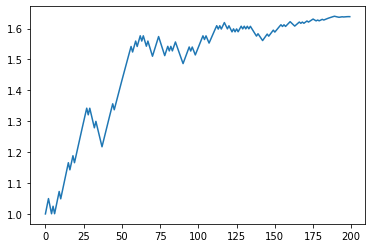

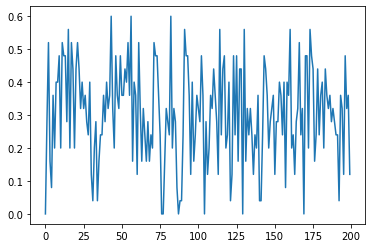

In [6]:
plt.plot(cov_scale_hist)
plt.show()
plt.plot(acc_rate_hist)
plt.show()

Acceptance rate = 30.54


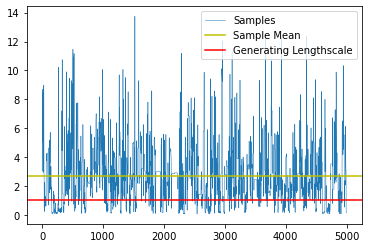

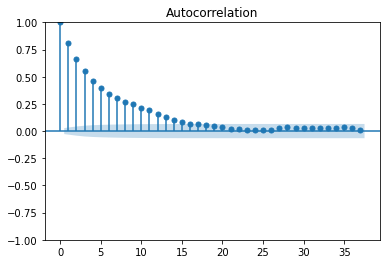

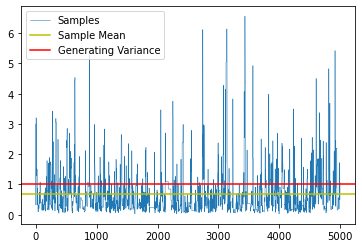

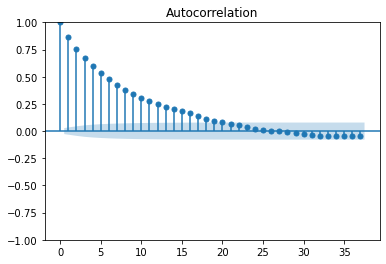

In [7]:
print(f'Acceptance rate = {move_arr.mean()*100}')

plt.plot(np.exp(th_arr[:, 0]) + 0.05, label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_lengthscale, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plot_acf(np.exp(th_arr[:, 0]))
plt.show()

plt.plot(np.exp(th_arr[:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_variance, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()

plot_acf(np.exp(th_arr[:, 1]))
plt.show()

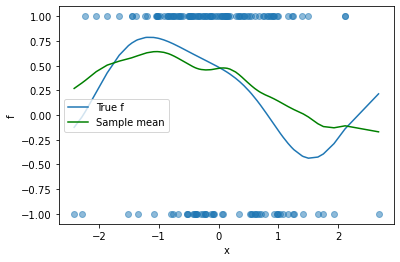

In [8]:
sort_ix = np.argsort(x.reshape(-1))

plt.xlabel('x')
plt.ylabel('f')
for i in range(f_arr.shape[0], 100):
    plt.plot(x[sort_ix], f_arr[i, :][sort_ix], c = 'r', linewidth = 0.1, alpha = 0.8)
    
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr.mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.scatter(x, y, alpha=0.5)

plt.legend()
plt.show()

In [12]:
from gproc.pseudo_marginal_prediction import pm_predict

#pm_predict(np.array([0.0]), x, y, SquaredExponential, f_arr, th_arr, inverse_gram_arr)
pred_xs = np.linspace(-2.5,2.5,100).reshape((100,1))
pred_probs = np.empty(100)
for i in tqdm(range(100)):
    pred_probs[i] = pm_predict(pred_xs[i,:], x, y, SquaredExponential, f_arr, th_arr, inverse_gram_arr)
    


  0%|          | 0/100 [00:00<?, ?it/s]

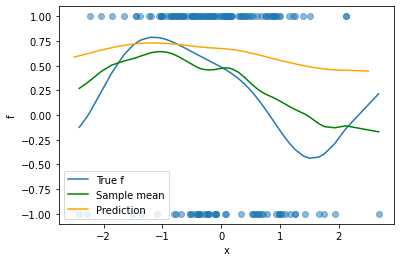

In [13]:
plt.xlabel('x')
plt.ylabel('f')
for i in range(f_arr.shape[0], 100):
    plt.plot(x[sort_ix], f_arr[i, :][sort_ix], c = 'r', linewidth = 0.1, alpha = 0.8)
    
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr.mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.plot(pred_xs, pred_probs, c='orange', label="Prediction")
plt.scatter(x, y, alpha=0.5)

plt.legend()
plt.show()

In [11]:
pred_probs

array([0.58698408, 0.59277377, 0.59890536, 0.60523521, 0.61163682,
       0.61804119, 0.62440909, 0.63071331, 0.63693573, 0.64306768,
       0.64910636, 0.65504506, 0.66086701, 0.66655101, 0.67207829,
       0.67743109, 0.68259348, 0.6875581 , 0.69232393, 0.69688299,
       0.70121507, 0.7052956 , 0.70910262, 0.71261713, 0.71582269,
       0.718706  , 0.7212565 , 0.72346674, 0.725334  , 0.7268612 ,
       0.72805605, 0.72892791, 0.72948438, 0.72973007, 0.72966822,
       0.72930323, 0.72864205, 0.72769405, 0.72647071, 0.72498613,
       0.72325747, 0.72130393, 0.71914471, 0.71679785, 0.71428125,
       0.71161536, 0.70882557, 0.70594333, 0.70300601, 0.70005629,
       0.69714157, 0.69431261, 0.69161971, 0.68910617, 0.68680136,
       0.68471605, 0.68284053, 0.68114437, 0.67957811, 0.678078  ,
       0.67657324, 0.67499283, 0.67327067, 0.6713494 , 0.6691831 ,
       0.66673757, 0.66398698, 0.66090977, 0.65748742, 0.65370722,
       0.64956669, 0.64507679, 0.64026219, 0.63515838, 0.62980